#Phase 1 (set-up)

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

In [7]:
# define headers
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=columns, skipinitialspace=True, na_values='?')
display(df.head())
df.shape

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(32561, 15)

#Phase 2 (Data-preprocessing)

In [8]:
#Clean Missing Data
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(0)

#Encoding Target Variable (Income)
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

#Feature Engineering (Lets us One-Hot Encoding)
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country']

df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("New The shape:", df_processed.shape)

New The shape: (32561, 101)


#Phase 3 (Handle the imbalances)

In [10]:
X = df_processed.drop('income', axis=1)
y = df_processed['income']

#Split(80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#SMOTE (Upsampling)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original Training Count: {len(y_train)}")
print(f"Upsampled Training Count: {len(y_train_resampled)} (Now Balanced)")

Original Training Count: 26048
Upsampled Training Count: 39556 (Now Balanced)


#Phase 4 (Train)

In [12]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

#Phase 5 (Evaluating the model)

In [15]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC


acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

In [16]:
print(f"Accuracy: {acc:.2f}")
print(f"AUC Score: {auc:.2f}")

Accuracy: 0.85
AUC Score: 0.91


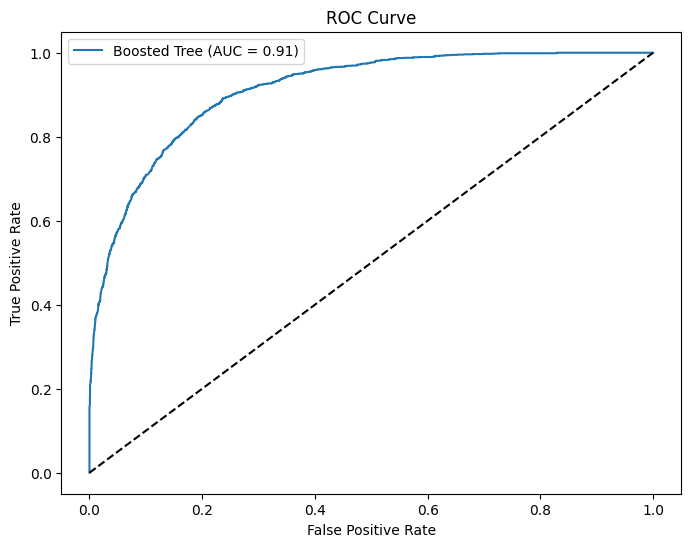

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Boosted Tree (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#-------------------------------------------------------------------------------------------------------


#Beta: Deployment

In [18]:
import joblib

joblib.dump(model, 'census_income_model.joblib')
print("Model saved as 'census_income_model.joblib'")

Model saved as 'census_income_model.joblib'


#testing

In [20]:
loaded_model = joblib.load('census_income_model.joblib')

test_input = X_test.iloc[0:1]


prediction = loaded_model.predict(test_input)
probability = loaded_model.predict_proba(test_input)[0][1]

print(f"Loaded Model Prediction: {'>50K' if prediction[0] == 1 else '<=50K'}")
print(f"Confidence: {probability:.2%}")

Loaded Model Prediction: <=50K
Confidence: 7.31%


The model is 92.69% sure that this individual earns less than $50,000. This demonstrates the model's capability to distinguish low-income profiles with high certainty.